<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/Modeling_and_Prediction_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM

In diesem Skript wird ein erstes Modell erzeugt, um aus den gemssenen Globalstrahlungsdaten den UVI zu berechen.

In [1]:
# Verbinden mit der Google-Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow == 2.6.0

ERROR: Invalid requirement: '==': Expected package name at the start of dependency specifier
    ==
    ^


In [3]:
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Pfad zur CSV-Datei auf Google Drive
name_Messwerte = 'Messdaten_CAMS_GHI.csv'
name_Vorhersage = 'Vorhersagedaten_CAMS_VarIdx.csv'
folder_import = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'

In [5]:
# Import der Messdaten
df_Messdaten = pd.read_csv(folder_import + name_Messwerte)

In [6]:
# Import der Vorhersagedaten
df_Vorhersage = pd.read_csv(folder_import + name_Vorhersage)

In [7]:
# Konvertiere die Zeitspalten in ein gemeinsames Format und führe einen Merge der Datensätze durch
df_Messdaten['Datetime'] = pd.to_datetime(df_Messdaten['Datetime'])
df_Vorhersage['Datetime'] = pd.to_datetime(df_Vorhersage['Datetime'])

In [8]:

df_Messdaten.columns

Index(['Datetime', 'Observation_period', 'Clear_sky_GHI', 'Clear_sky_BHI',
       'GHI', 'BHI', 'UVI', 'UVA', 'UVB', 'erythem', 'Datum', 'Uhrzeit',
       'Messzeitpunkt', 'ghi', 'Dif', 'Glo_SPLite', 'Dir', 'Temp',
       'DiffGreater2', 'SZA', 'time_sin', 'time_cos', 'date_sin', 'date_cos',
       'Date', 'Hour'],
      dtype='object')

In [9]:
# Relevante Spalten
indipendent_variablen = ['ghi', 'SZA', 'time_sin', 'time_cos', 'date_sin', 'date_cos']
dependent_variablen = ['UVI']

columns = indipendent_variablen + dependent_variablen

In [10]:
#Applying a scaler for regression
MMS = MinMaxScaler()
df_Messdaten[columns] = MMS.fit_transform(df_Messdaten[columns])

In [11]:
#Splitting in training and testing samples
training_size = round(len(df_Messdaten) * 0.80)
train_data = df_Messdaten[columns][:training_size]
test_data  = df_Messdaten[columns][training_size:]

print(train_data, test_data)

            ghi       SZA  time_sin  time_cos  date_sin  date_cos       UVI
0      0.449763  0.394655  0.969096  0.403006  0.641161  0.020303  0.281919
1      0.452447  0.390193  0.969096  0.403006  0.641161  0.020303  0.281919
2      0.455624  0.385734  0.967568  0.397968  0.641161  0.020303  0.288240
3      0.458118  0.381277  0.966004  0.392947  0.641161  0.020303  0.290191
4      0.463850  0.376825  0.964405  0.387943  0.641161  0.020303  0.297739
...         ...       ...       ...       ...       ...       ...       ...
77381  0.342308  0.574718  0.058526  0.326979  0.971797  0.334079  0.093193
77382  0.152062  0.579150  0.056495  0.331739  0.971797  0.334079  0.078514
77383  0.125504  0.583587  0.054497  0.336521  0.971797  0.334079  0.070488
77384  0.108314  0.588028  0.052533  0.341323  0.971797  0.334079  0.067234
77385  0.095241  0.592473  0.050603  0.346147  0.971797  0.334079  0.062044

[77386 rows x 7 columns]             ghi       SZA  time_sin  time_cos  date_sin  date_

In [12]:
def create_sequence(dataset,sequence_len):
  sequences = []
  labels = []
  start_idx = 0
  for stop_idx in range(sequence_len,len(dataset)):
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences),np.array(labels))

In [13]:
# Erstellen des Trainigs- und Validierungsdatensatzes
X_train, y_train = create_sequence(train_data,100)
X_val, y_val = create_sequence(test_data,100)

print(X_train.shape, X_val.shape)

(77286, 100, 7) (19246, 100, 7)


In [14]:
#Creating LSTM for regression

model = Sequential()
model.add(LSTM(units = 64, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units = 32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
history = model.fit(X_train, y_train, epochs = 4, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/4
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 251s 102ms/step - loss: 0.0969 - mean_absolute_error: 0.2715 - val_loss: 0.0800 - val_mean_absolute_error: 0.2346
Epoch 2/4
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 265s 103ms/step - loss: 0.0954 - mean_absolute_error: 0.2697 - val_loss: 0.0799 - val_mean_absolute_error: 0.2363
Epoch 3/4
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 263s 104ms/step - loss: 0.0957 - mean_absolute_error: 0.2701 - val_loss: 0.0799 - val_mean_absolute_error: 0.2343
Epoch 4/4
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 267s 106ms/step - loss: 0.0954 - mean_absolute_error: 0.2696 - val_loss: 0.0799 - val_mean_absolute_error: 0.2347


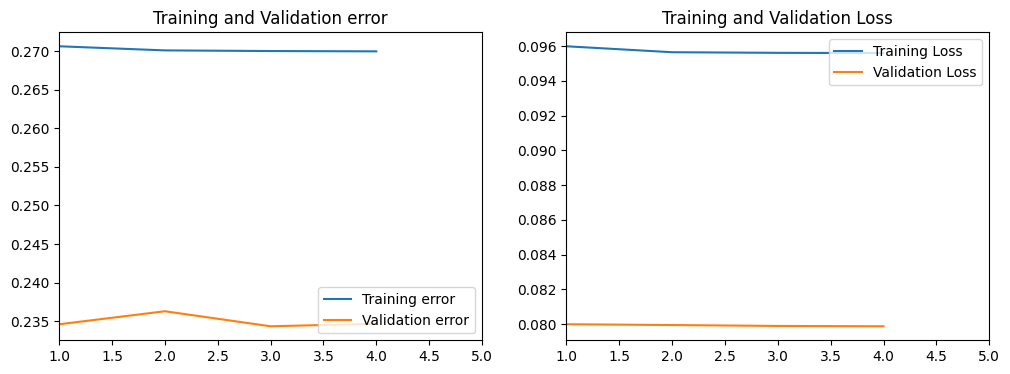

In [16]:
#Plot of error and loss
error = history.history['mean_absolute_error']
val_error = history.history['val_mean_absolute_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(val_error)+1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, error, label='Training error')
plt.plot(epochs_range, val_error, label='Validation error')
plt.legend(loc='lower right')
plt.xlim(1, len(val_error)+1)
plt.title('Training and Validation error')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(1, len(val_error)+1)
plt.title('Training and Validation Loss')
plt.show()

602/602 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step


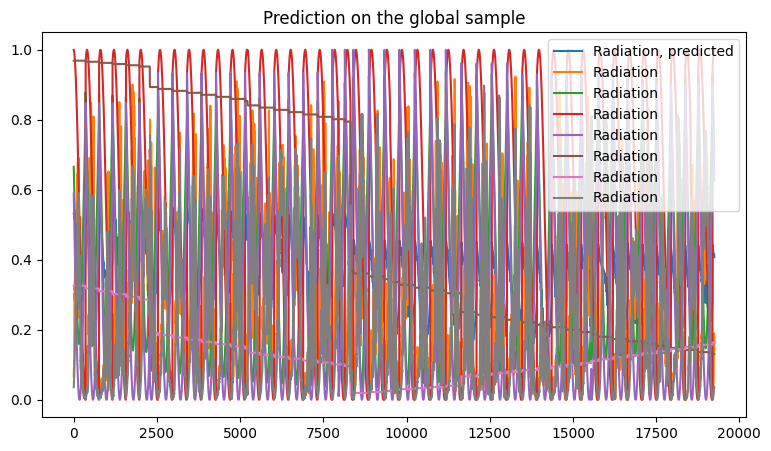

In [17]:
test_predicted = model.predict(X_val)

fig=plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(test_predicted,label='Radiation, predicted')
plt.plot(y_val,label="Radiation")
plt.title('Prediction on the global sample')
plt.legend()

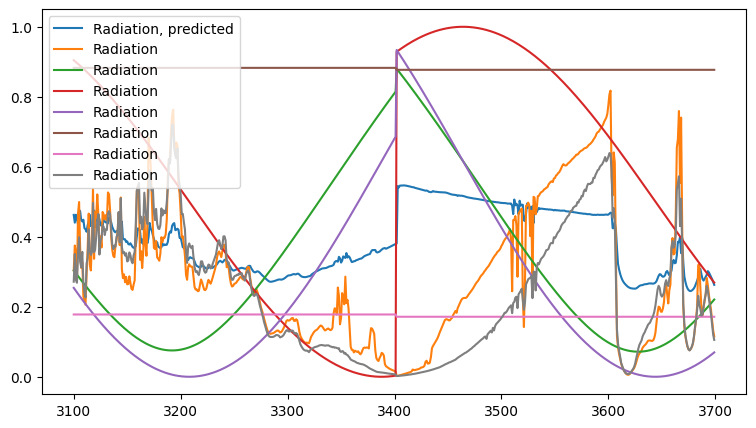

In [18]:
fig=plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(np.arange(3100,3700),test_predicted[3100:3700],label='Radiation, predicted')
plt.plot(np.arange(3100,3700),y_val[3100:3700],label="Radiation")
plt.legend()